In [5]:
import tensorflow as tf
import pickle
import os

def save(data, filename):
    file = open(filename, 'wb')
    pickle.dump(data, file)
    file.close()

def load(filename):
    if not os.path.exists(filename):
        return NULL
    file = open(filename, 'rb')
    data = pickle.load(file)
    file.close()
    return data
    
taxonomyList = load('PocData/taxonomyList_r.pkl')
docs = load('PocData/docs.pkl')
print(len(docs))

8601


In [6]:
from nltk.tokenize import RegexpTokenizer
from tensorflow.contrib import learn
import numpy as np

max_document_length = 500
min_frequency = 2

def docs2x(docs):
    # 去除符号 字母小写
    tokenizer = RegexpTokenizer(r'\w+')
    data = []
    for doc in docs:
        data.append(" ".join(tokenizer.tokenize(doc['x'].lower())))
        
    # 构建字典 word to index
    print(data[0])
    vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length, min_frequency)
    x = np.array(list(vocab_processor.fit_transform(data)))
    
    print("vocabulary size: {:d}".format(len(vocab_processor.vocabulary_)))
    vocab_processor.save('data/vocabulary.vocab')
    return x

x = docs2x(docs)
print((x[0]))

conduct of parties whether defendant husband entitled to ancillary financial relief where decree of nullity of marriage granted where defendant was transsexual whether defendant guilty of perjury in going through ceremony of marriage with plaintiff where defendant knew that he could not validly marry a woman whether defendant s conduct sufficiently culpable to fall within public policy principle preventing person guilty of serious crime from benefiting from offence whether where marriage contracted in circumstances involving commission of serious offence guilty party debarred from making claim for ancillary relief whether parliament distinguished between decrees of nullity in empowering courts to entertain ancillary relief applications whether legitimate to take account of public policy principles as guide to exercise of court s discretion no ancillary relief granted in favour of defendant considered distinguished distinguished cited considered applied applied referred to referred to r

In [ ]:
# vocabulary restore and transform
tokenizer = RegexpTokenizer(r'\w+')
_vocab_processor = learn.preprocessing.VocabularyProcessor.restore('data/vocabulary.vocab')
print(len(_vocab_processor.vocabulary_))
doc = tokenizer.tokenize(docs[0]['x'].lower())
_x = list(_vocab_processor.transform(doc))

In [7]:
# deal with y in docs
y = []
for doc in docs:
    y.append(doc['y'])
y = np.array(y)

In [8]:
# data shuffle
n_sample = len(y)
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(n_sample))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]
print(len(y_shuffled))

8601


In [9]:
# 训练样本/测试样本 split
sample_rate = .1
dev_sample_index = -1 * int(sample_rate * float(n_sample))
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]
print("train/test split: {:d}/{:d}".format(len(y_train), len(y_dev)))

train/test split: 7741/860


In [10]:
# fasttext
def FastText(input_x, dropout_keep_prob, sequence_length, num_classes, vocab_size, embedding_size):
    # Embedding layer
    with tf.device('/cpu:0'), tf.name_scope("embedding"):
        w0 = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
        embedded_chars = tf.nn.embedding_lookup(w0, input_x)

        h = tf.reduce_mean(embedded_chars, axis=1)

        # Final (unnormalized) scores and predictions
        W = tf.Variable(tf.random_normal([embedding_size, num_classes], mean=0.0, stddev = 0.2))
        b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
        logits = tf.nn.xw_plus_b(h, W, b, name="logits")
        return logits

In [11]:
# batch method
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [15]:
# hyper parameters
embedding_dim = 100
dropout_keep_prob = 0.6
fcsize = 250
batch_size = 80
num_epochs = 60

learning_rate = 0.01
evaluate_every = 100

num_classes=y_train.shape[1]
sequence_length=x_train.shape[1]
vocabulary_len = len(_vocab_processor.vocabulary_)

# build the network graph
train_graph = tf.Graph()
with train_graph.as_default():
    lr = tf.placeholder(tf.float32, name='LearingRate')
    dropout_keep = tf.placeholder(tf.float32, name='dropout')
    input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
    input_y = tf.placeholder(tf.int32, [None, num_classes], name="input_y")

    logits = FastText(
        input_x,
        dropout_keep,
        sequence_length, 
        num_classes, 
        vocabulary_len, 
        embedding_dim)
    
    logits = tf.identity(logits, name='logits')

    # Loss and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_y))
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    # Accuracy
    index_predict = tf.argmax(logits, 1)
    index_target = tf.argmax(input_y, 1)
    correct_pred = tf.equal(index_predict, index_target)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy') 
    
    def train_step(x_batch, y_batch):
        """
        A single training step
        """
        feed_dict = {
          input_x: x_batch,
          input_y: y_batch,
          dropout_keep: dropout_keep_prob,
          lr: learning_rate
        }
        _, _loss, _accuracy = sess.run(
            [optimizer, cost, accuracy],
            feed_dict)
        print("loss {:g}, acc {:g}".format(_loss, _accuracy))
        return _accuracy

    def dev_step(x_batch, y_batch):
        """
        Evaluates model on a dev set
        """
        feed_dict = {
          input_x: x_batch,
          input_y: y_batch,
          dropout_keep: 1.0
        }
        _loss, _accuracy = sess.run(
            [cost, accuracy],
            feed_dict)
        print("loss {:g}, acc {:g}".format(_loss, _accuracy))

In [16]:
# train    
batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    # Generate batches
    # Training loop. For each batch...
    step = 1
    acc_result = []
    for batch in batches:
        x_batch, y_batch = zip(*batch)
        
        print("batch {}".format(step))
        acc = train_step(x_batch, y_batch)
        
        if step % 20 == 0:
            acc_result.append(acc)
        step = step + 1
        
    saver = tf.train.Saver(tf.global_variables(), max_to_keep=3)
    save_model_path = 'data/trained_model'
    path = saver.save(sess, save_model_path)
    print("Saved model checkpoint to {}\n".format(path))
        

batch 1
loss 2.75169, acc 0.0875
batch 2
loss 2.80062, acc 0.05
batch 3
loss 2.75806, acc 0.1125
batch 4
loss 2.73242, acc 0.1
batch 5
loss 2.78138, acc 0.0875
batch 6
loss 2.76383, acc 0.1125
batch 7
loss 2.6646, acc 0.1875
batch 8
loss 2.73253, acc 0.05
batch 9
loss 2.72678, acc 0.1125
batch 10
loss 2.70935, acc 0.15
batch 11
loss 2.73569, acc 0.125
batch 12
loss 2.66667, acc 0.1625
batch 13
loss 2.6921, acc 0.2
batch 14
loss 2.69783, acc 0.15
batch 15
loss 2.71902, acc 0.1125
batch 16
loss 2.64224, acc 0.1625
batch 17
loss 2.68013, acc 0.15
batch 18
loss 2.68492, acc 0.1625
batch 19
loss 2.67469, acc 0.125
batch 20
loss 2.70132, acc 0.175
batch 21
loss 2.69648, acc 0.1625
batch 22
loss 2.64025, acc 0.2125
batch 23
loss 2.69353, acc 0.1
batch 24
loss 2.73069, acc 0.1375
batch 25
loss 2.67574, acc 0.1125
batch 26
loss 2.64067, acc 0.1625
batch 27
loss 2.66656, acc 0.125
batch 28
loss 2.64033, acc 0.1375
batch 29
loss 2.6351, acc 0.15
batch 30
loss 2.64103, acc 0.175
batch 31
loss 2.64

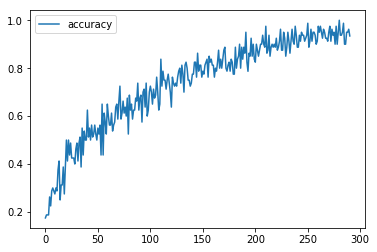

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(acc_result, label='accuracy')
plt.legend()

In [18]:
try:
    if batch_size:
        pass
except NameError:
    batch_size = 100
save_model_path = 'data/trained_model'

graph = tf.Graph()

with graph.as_default():
    sess = tf.Session()
    with sess.as_default():
        sess.run(tf.global_variables_initializer())
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
#         print([n.name for n in tf.get_default_graph().as_graph_def().node])
        input_y = graph.get_operation_by_name("input_y").outputs[0]
        input_x = graph.get_operation_by_name("input_x").outputs[0]
        dropout_keep_prob = graph.get_operation_by_name("dropout").outputs[0]
        logits = graph.get_operation_by_name("logits").outputs[0]

        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(input_y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        feed_dict = {
          input_x: x_dev,
          input_y: y_dev,
          dropout_keep_prob: 1.0
        }
        _accuracy = sess.run([accuracy], feed_dict)
        print(_accuracy)



[0.66860467]
